In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob
import random
import shutil
from keras.preprocessing.image import load_img, img_to_array
#import bcolz
import csv
import subprocess
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import DenseNet121
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import cv2
import tensorflow as tf
import keras
from keras.models import Model, Sequential 
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
%matplotlib inline
print ("TensorFlow version: " + tf.__version__)

Using TensorFlow backend.


TensorFlow version: 1.13.1


In [2]:
img_path="data/xray_chest/images/"
img_height=224 #299
img_width=224 #299

In [ ]:
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

def plot_img(img, title, count, cols, plot_axis=False):
    a = fig.add_subplot(1, cols, count)
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        plt.imshow(img)
    else:
        plt.imshow(load_img(img))
    a.set_title(title,fontsize=10)
    if plot_axis is False:
        plt.axis('off')

In [ ]:
def create_label_directories(csv_filename, img_path, is_one_v_all=False, one_v_all_label="Pneumonia"):
    directories = set()
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(csvfile) # skip header row
        for row in reader:
            img_filename = str(row[0])
            labels = str(row[1])
            for label in labels.split('|'):
                if (is_one_v_all is True) and (label != one_v_all_label):
                    label = "ALL"
                src_file = os.path.join(img_path,img_filename)
                label = "_".join(label.split())
                dst_train_dir = os.path.join(img_path,"train",label)
                dst_train_file = os.path.join(dst_train_dir,img_filename)
                dst_valid_dir = os.path.join(img_path,"valid",label)
                dst_test_dir = os.path.join(img_path,"test",label)
                if not os.path.exists(dst_train_dir):
                    os.makedirs(dst_train_dir)
                    directories.add(label)
                if not os.path.exists(dst_valid_dir):
                    os.makedirs(dst_valid_dir)
                if not os.path.exists(dst_test_dir):
                    os.makedirs(dst_test_dir)
                src_file_abs = os.path.join(os.getcwd(),src_file)
                dst_train_file_abs = os.path.join(os.getcwd(),dst_train_file)
                #print("copy: " + src_file_abs + " to: " + dst_train_file_abs)
                if not os.path.exists(dst_train_file_abs):
                    os.symlink(src_file_abs, dst_train_file_abs)
    return list(directories)

is_one_v_all = True
one_v_all_label = "Pneumonia"
print(img_path)
directories = create_label_directories("data/xray_chest/Data_Entry_2017.csv", img_path, is_one_v_all, one_v_all_label)
print(directories)

In [ ]:
def get_per_label_count(directories):
    per_label_count = []
    for ii in range(len(directories)):
        #print(directories[ii])
        path, dirs, files = os.walk(os.path.join(img_path,"train",directories[ii])).__next__()
        file_count = len(files)
        per_label_count.append(file_count)
    return per_label_count
        
print(directories)
per_label_count = get_per_label_count(directories) 
print(per_label_count)

In [ ]:
def upsample(directories, per_label_count, iqr):
    for ii in range(len(per_label_count)):
        label = directories[ii]
        count = per_label_count[ii]
        if count < iqr:
            offset = iqr-count
#            subprocess.call(['./batch-augment.sh', os.path.join(os.getcwd(),img_path,"train",label), str(offset)])
    return get_per_label_count(directories)

print(directories)
print(per_label_count)
#print(label_batch_size)
per_label_count_upsampled = upsample(directories, per_label_count, 8430)#label_batch_size)
print(per_label_count_upsampled)

In [ ]:
def downsample(directories, per_label_count):
    label_idx = np.argmin(per_label_count)
    #print(label_idx)
    downsample_count = per_label_count[label_idx]
    #print(downsample_count)
    for ii in range(len(per_label_count)):
        label = directories[ii]
        src_train_dir = os.path.join(img_path,"train",label)
        all_img_paths = glob.glob(os.path.join(src_train_dir,"*.*"))
        np.random.shuffle(all_img_paths)
        if len(all_img_paths) != downsample_count:
            imgs_to_remove = all_img_paths[downsample_count:]
            #print(len(imgs_to_remove))
            for file in imgs_to_remove:
                file_abs = os.path.join(os.getcwd(),file)
                #print("remove file: " + file_abs)
                os.remove(file_abs)
    return get_per_label_count(directories)
                
print(directories)
print(per_label_count_upsampled)
per_label_count_downsampled = downsample(directories, per_label_count_upsampled)
print(per_label_count_downsampled)

In [ ]:
def split_train_valid_test(directories, per_label_count, valid_pct, test_pct):
    for ii in range(len(directories)):
        all_img_paths = glob.glob(os.path.join(img_path,"train",directories[ii],"*.*"))
        np.random.shuffle(all_img_paths)
        label_count = per_label_count[ii]
        valid_count = int(label_count*valid_pct)
        valid_files = all_img_paths[:valid_count]
        all_img_paths[:valid_count] = []
        test_count = int(label_count*test_pct)
        test_files = all_img_paths[:test_count]
        all_img_paths[:test_count] = []
        #print(len(valid_files))
        #print(len(test_files))
        train_files = all_img_paths
        all_img_paths = []
        #print(len(train_files))
        for valid_file in valid_files:
            valid_file_abs = os.path.join(os.getcwd(),valid_file)
            #print("move: '" + valid_file_abs + "' to: '" + os.path.join(img_path,"valid",directories[ii]))
            shutil.move(valid_file_abs, os.path.join(img_path,"valid",directories[ii]))
        for test_file in test_files:
            test_file_abs = os.path.join(os.getcwd(),test_file)
            #print("move: '" + test_file_abs + "' to: '" + os.path.join(img_path,"test",directories[ii]))
            shutil.move(test_file_abs, os.path.join(img_path,"test",directories[ii]))
        

valid_pct = 0.01 # 0.1
test_pct = 0.98 # 0.1       
print(directories)
print(per_label_count_downsampled)
split_train_valid_test(directories, per_label_count_downsampled, valid_pct, test_pct)

In [ ]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True, 
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    'data/xray_chest/images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    'data/xray_chest/images/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size, #val_batch_size,
    class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    'data/xray_chest/images/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

In [ ]:
model = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model.summary()

In [ ]:
#model.load_weights('weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.1, momentum=0.9, nesterov=True), metrics=['accuracy'])

In [ ]:
filepath="weights.best.DenseNet121-nih-one-v-all-fibrosis.20180305-r1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=500)
callbacks_list = [checkpoint,early_stopping]#,tensorboard]

Initial dataset modified to work with this dataset.

In [3]:
# Final image resolution
res = 64

# Crop images to squares
def to_square(img):
    (h, w) = img.shape
    diff_half = np.abs(h-w) // 2
    
    if w > h:
        return(img[0:h, 0+diff_half:w-diff_half])
    elif w < h:
        return(img[0+diff_half:w-diff_half, 0:w])
    else: 
        return img

def load_data(dataset='train'):
    
    # Path where files are stored
    files_path = 'data/xray_chest/images/'+dataset
    
    #--- STEP 1: Create list containing names of image files ---#
    names_list = []
    for cat in ['/ALL', '/Pneumonia']:
        for img_name in os.listdir(files_path+cat):
            # Exclude non-image files
            if img_name[0] in ['I', 'N', 'p']:
                names_list.append(img_name)
    # Shuffle to feed into network
    random.Random(232).shuffle(names_list)
    
    #--- STEP 2: Create list of labels ---#
    labels = []
    for img_name in names_list:
        # 0 for normal, 1 for pneumonia
        if img_name[0] in ['I', 'N']:
            labels.append(0)
        elif img_name[0] == 'p':
            labels.append(1)
            
    #--- STEP 3: Load images and process them ---#
    img_list = []
    for img_name in tqdm(names_list):
        try:
            # Load images 
            if img_name[0] in ['I', 'N']:
                img = plt.imread(files_path+'/ALL/'+img_name)
            elif img_name[0] == 'p':
                img = plt.imread(files_path+'/Pneumonia/'+img_name)
                
            # Process images (normalize, square, reduce resolution)
            if len(img.shape) == 3:
                img = img[:,:,0]
            img = img / 255
            img = to_square(img)
            img = cv2.resize(img, dsize=(res, res), interpolation=cv2.INTER_AREA)
            img = img.reshape(res, res, 1)
            img = np.dstack([img, img, img])
            img_list.append(img)
        except OSError:
            pass
    
    return np.array(img_list), np.array(labels)

In [4]:
# Load data into each dataset pair
x_train, y_train = load_data(dataset='train')
x_val, y_val = load_data(dataset='valid')
x_test, y_test = load_data(dataset='test')

IndexError: index 0 is out of bounds for axis 0 with size 0

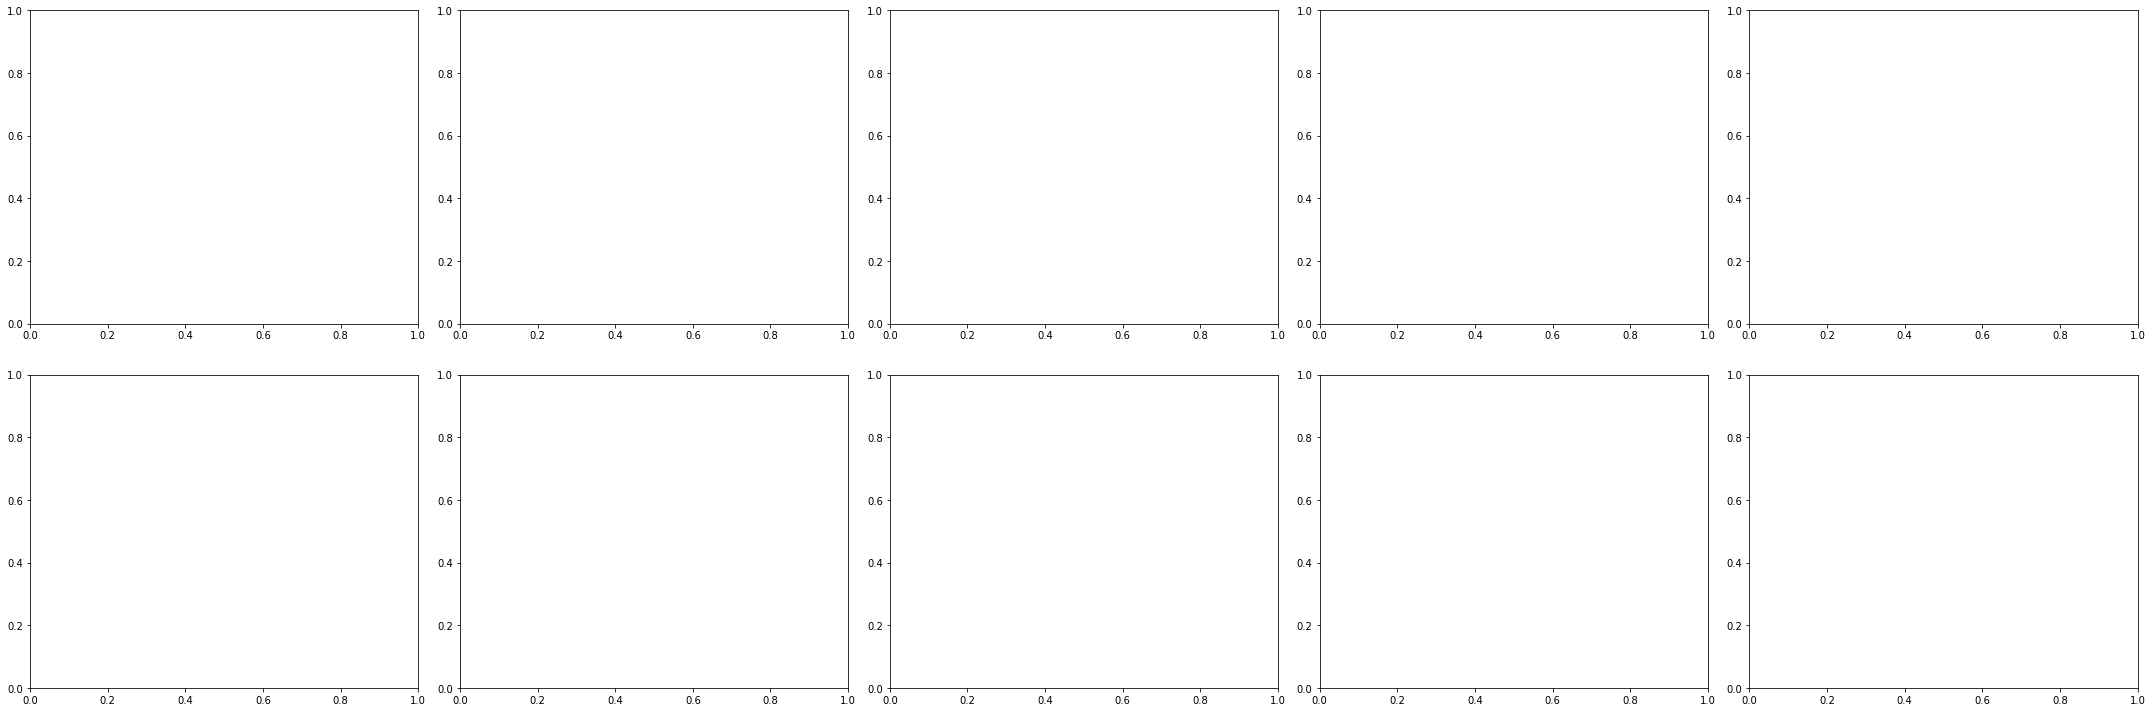

In [5]:
# Visualizing xrays
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
ax = ax.ravel()
plt.tight_layout(h_pad=3)

for i in range(ax.shape[0]):
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].set_title('label = {}'.format(y_test[i]))

In [ ]:
# Model parameters
ks33 = (3, 3)
ks22 = (2, 2)

In [ ]:
# Design model with Keras Functional API 
inputs = Input(shape=(res, res, 3))

# Convolutional layer 1
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(inputs)
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv1 = MaxPool2D(pool_size=(2, 2))(conv1)

# Convolutional layer 2
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPool2D(pool_size=(2, 2))(conv2)

# Convolutional layer 3
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPool2D(pool_size=(2, 2))(conv3)

# Fully-Connected layer
fc = Flatten()(conv3)
fc = Dense(units=256, activation='relu')(fc)
fc = Dropout(rate=0.5)(fc)
fc = Dense(units=64, activation='relu')(fc)
fc = Dropout(rate=0.2)(fc)

# Output
output = Dense(units=1, activation='sigmoid')(fc)

# Create model and compile
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary
print(model.summary())

In [ ]:
# Callbacks and image preprocessing

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
img_aug = ImageDataGenerator(rotation_range=20, vertical_flip=True, horizontal_flip=True)
img_aug.fit(x_train)

In [ ]:
# Hyperparameters for fitting
batch_size = 74
epochs = 40
steps = x_train.shape[0] // batch_size

# Fitting model to data (val set too small, use test for validation)
model.fit_generator(img_aug.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=(x_test, y_test), callbacks=[reduce_lr], 
                    verbose=1)

In [ ]:
# Metrics

# Getting predictions
predictions = model.predict(x=x_test)

acc = accuracy_score(y_test, np.round(predictions))*100
tn, fp, fn, tp = confusion_matrix(y_test, np.round(predictions)).ravel()

print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(tp/(tp+fp)*100))
print('Recall: {}%'.format(tp/(tp+fn)*100))

In [ ]:
print(confusion_matrix(y_test, np.round(predictions)).ravel())

Back to orginal code

In [ ]:
#nb_train_samples = 16188 #8094 #3036 #18046 #111589 #113243 #139987 
nb_train_samples = 88
nb_validation_samples= 336 
epochs = int(nb_train_samples/batch_size)*3
history = model.fit_generator(
    train_generator,
    steps_per_epoch=batch_size, #nb_train_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    callbacks=callbacks_list,
    verbose=1)

In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

# requires history=model.fit, fit_generator...
plot_history(history)

In [ ]:
scores = model.evaluate_generator(test_generator, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False)
print("score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))

In [ ]:
preds = model.predict_generator(test_generator, steps=10, max_queue_size=10, workers=1, use_multiprocessing=False)
preds.shape

In [ ]:
#print(test_generator.classes)
steps = 11 #int(SIZE?/batch_size)
preds = np.zeros((0,2))
y_test = np.zeros((0,2))
step_count = 0
for batch_x, batch_y in test_generator:
    if step_count < steps:
        batch_preds = model.predict(batch_x)
        #print(batch_preds.shape)
        preds = np.vstack((preds,batch_preds))
        #print(batch_y)
        y_test = np.vstack((y_test,batch_y))
        step_count = step_count + 1
    else:
        break
        
print(preds.shape)
print(y_test.shape)

In [ ]:
y_trues = [np.argmax(ii) for ii in y_test]
y_preds = [np.argmax(ii) for ii in preds]

# credit: https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/    
def plot_binary_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    classNames = classes
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    
cm = confusion_matrix(y_trues, y_preds)
#print(cm)
tn, fp, fn, tp = cm.ravel()
#print(tn, fp, fn, tp)

# Plot non-normalized confusion matrix
plt.figure()
plot_binary_confusion_matrix(cm, classes=['Negative','Positive'], title='Confusion matrix, without normalization', cmap=plt.cm.Greens)
plt.show()